# Classification of the MNIST Dataset using MLP
---
In this notebook, I describe:
- Usage of the built-in dataset.
- How to define and train a neural network.
- Training on gpu.

__packages:__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, sampler
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from typing import List

## What we create
We will create the three layered fully-connected neural network.  
The structure of the network are described in [here in Githhub](https://github.com/kattoyoshi/NeuralNetworkFromScratch).

## Load the data
The datasets are provided as PIL images of range [0,1]. We transform them to Tensors.

In [2]:
# Define a transform object to read the data as a tensor with normalize (0~1)
data_transform = transforms.Compose([
    transforms.ToTensor()
    ])


# Download datasets
train_data = MNIST(root='./data', train=True, transform=data_transform, download=True)
test_data = MNIST(root='./data', train=False, transform=data_transform, download=True)

## Iteration and batching

\- Extract validation data from training dataset

In [3]:
valid_ratio = 0.2 # Use 20 % of the training dataset as a validation dataset

num_train = len(train_data)
indices = list(range(num_train))
split_idx = int(np.floor(valid_ratio * num_train))

valid_indices, train_indices = indices[:split_idx], indices[split_idx:]

print("n_train: ", len(train_indices))
print("n_valid: ", len(valid_indices))

n_train:  48000
n_valid:  12000


In [4]:
train_sampler = sampler.SubsetRandomSampler(train_indices)
valid_sampler = sampler.SubsetRandomSampler(valid_indices)

\- Prepare dataloader

In [5]:
# Train and test
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

## Visualize some training data

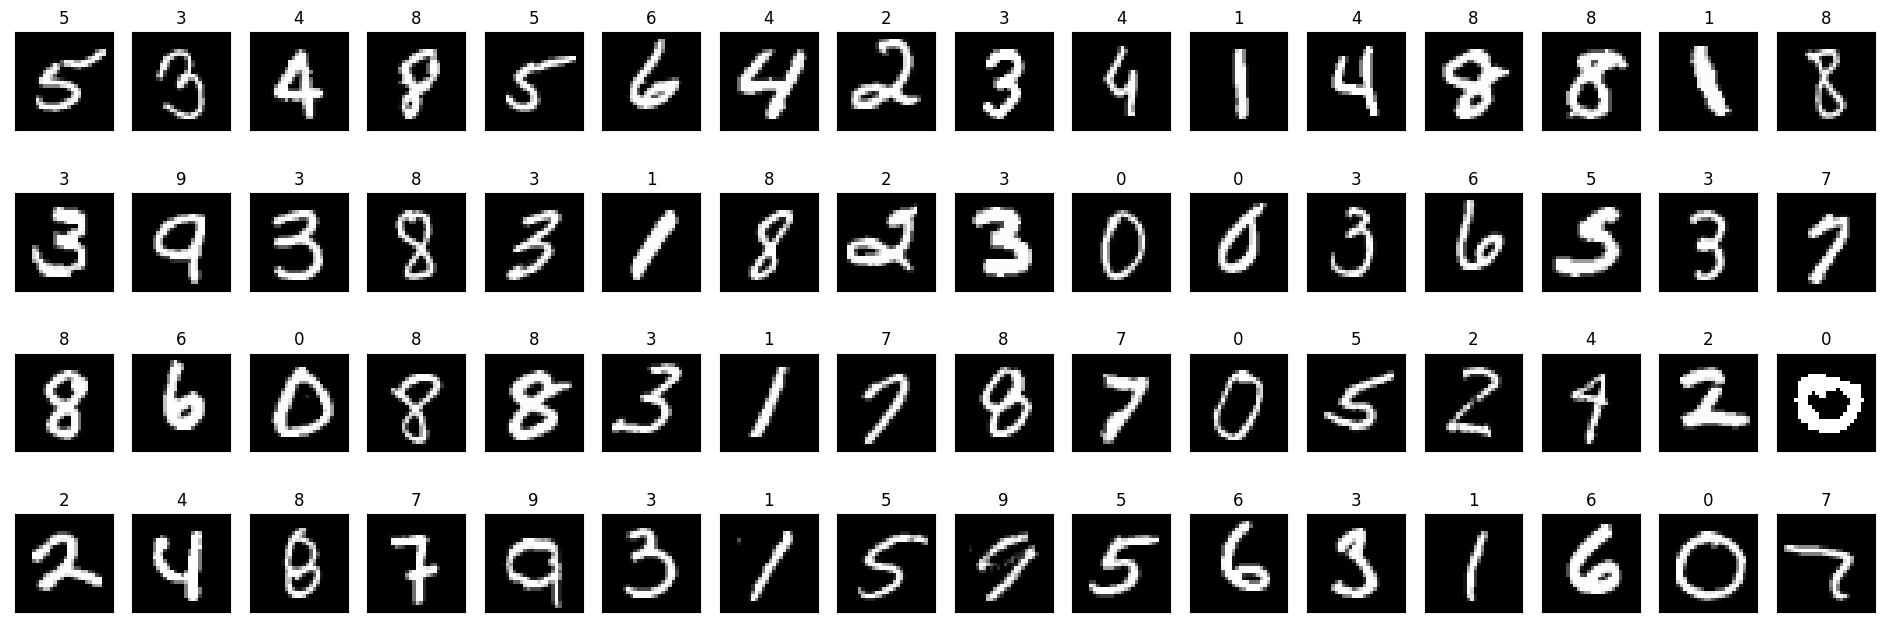

In [6]:
# define iterator
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot images
fig = plt.figure(figsize=(24, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(batch_size//16, 16, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(labels[idx].numpy())

## Define a network
To define a neural network in PyTorch, you have to create the network class as a sub-class of [nn.Module](https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module).

- Define the layers in `__init__`
- Refer to layers in `forward`

In [7]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        
        # first layer
        self.fc1 = nn.Linear(28*28, 256)
        # second layer
        self.fc2 = nn.Linear(256, 128)
        # output layer
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, X):
        """
        Forward pass of the network
        # Arguments
            X: input data
        # Returns
            Out: output data
        """
        # first layer
        X = F.relu(self.fc1(X))
        # second layer
        X = F.relu(self.fc2(X))
        # output layer
        logit = self.fc3(X)
        return logit # we output the logit (softmax is contained in the loss function)

### Instantiate a network (GPU)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# Instantinate model and convert parameters and buffers to CUDA tensors
net = MLP().to(device)
print(net)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## Optimizer
\- Loss Functions: [See documents here](https://pytorch.org/docs/stable/nn.html#loss-functions)  
\- Optimizers: [See documents here](https://pytorch.org/docs/stable/optim.html)

In [10]:
criterion = nn.CrossEntropyLoss() # softmax + NLLLloss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network
Steps:
1. Zero's the gradients to prepare for a forward pass
2. Calculate the outputs of the network (forward pass)
3. Computes the loss
4. Back propagates gradients (backward pass)
5. Updates the weights (parameter update)

__[Caution]__:  
The Variable API has been deprecated:  
Variables are no longer necessary to use autograd with tensors. Autograd automatically supports Tensors with `requires_grad` set to True.

In [11]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [12]:
def train(n_epochs: int, patience_n_epoch: int = 5) -> List[List[float]]:
    """
    # Arguments
        n_epochs (int): maximum epoch number of the training
        patience_n_epoch (int): maximum plateau epoch number of the validation loss

    # Returns
        history (List[List[float]]): list of [epoch, train_loss, validation_loss]
    """
    # parameters for early stopping
    best_valid_loss = np.inf
    cnt = 0
    
    loss_over_time = []
    history = []
    
    for epoch in range(n_epochs):
        train_loss = 0.0

        for iter_idx, data in enumerate(train_loader):
            # get input tensors
            inputs, labels = data
            # reshape the shape of the inputs data
            inputs = inputs.view(-1, 28 * 28)
            # set target device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Sets gradients of all model parameters to zero.
            optimizer.zero_grad()
            
            # forward pass
            logits = net(inputs)
            # calculate the loss
            loss = criterion(logits, labels)
            # backpropagatation
            loss.backward()
            # update the parameters
            optimizer.step()
            
            # accumurate loss values
            train_loss += loss.item()
        
        # Compute avaraged loss per batch
        train_loss = train_loss / iter_idx

        # evaluate the validation loss
        valid_loss = 0.0
        with torch.no_grad(): # Disabling gradient calculation
            for iter_idx, data in enumerate(val_loader):
                # get input tensors
                inputs, labels = data
                # reshape the shape of the inputs data
                inputs = inputs.view(-1, 28*28)
                # set target device
                inputs, labels = inputs.to(device), labels.to(device)
                # forward pass
                logits = net(inputs)
                # calculate the loss
                loss = criterion(logits, labels)
                valid_loss += loss.item()
        
        valid_loss = valid_loss / iter_idx
        print("Epoch: {}/{}, ".format(epoch + 1, n_epochs), 
              "train loss: {:.4f}".format(train_loss), 
              "val loss: {:.4f}".format(valid_loss))
        
        history.append([epoch + 1, train_loss, valid_loss])
        
        # define the rules for early stopping
        if valid_loss < best_valid_loss:
            print ("--- Validation loss improved from {0:.4f} to {1:.4f} ---".format(best_valid_loss, valid_loss))
            best_valid_loss = valid_loss
            cnt = 0
            # save model
            save_model(net, "saved_model/best_weight.pt")
        else:
            print ("Validation loss didn't improved")
            cnt += 1
            if cnt >= patience_n_epoch:
                print ("--- Stop training ---")
                break
    
    return history

In [13]:
history = train(60, 5)

Epoch: 1/60,  train loss: 1.9406 val loss: 1.1095
--- Validation loss improved from inf to 1.1095 ---
Epoch: 2/60,  train loss: 0.6956 val loss: 0.4960
--- Validation loss improved from 1.1095 to 0.4960 ---
Epoch: 3/60,  train loss: 0.4422 val loss: 0.3913
--- Validation loss improved from 0.4960 to 0.3913 ---
Epoch: 4/60,  train loss: 0.3755 val loss: 0.3469
--- Validation loss improved from 0.3913 to 0.3469 ---
Epoch: 5/60,  train loss: 0.3408 val loss: 0.3225
--- Validation loss improved from 0.3469 to 0.3225 ---
Epoch: 6/60,  train loss: 0.3171 val loss: 0.3015
--- Validation loss improved from 0.3225 to 0.3015 ---
Epoch: 7/60,  train loss: 0.2981 val loss: 0.2863
--- Validation loss improved from 0.3015 to 0.2863 ---
Epoch: 8/60,  train loss: 0.2827 val loss: 0.2690
--- Validation loss improved from 0.2863 to 0.2690 ---
Epoch: 9/60,  train loss: 0.2678 val loss: 0.2570
--- Validation loss improved from 0.2690 to 0.2570 ---
Epoch: 10/60,  train loss: 0.2550 val loss: 0.2465
--- Val

In [14]:
history = np.array(history)

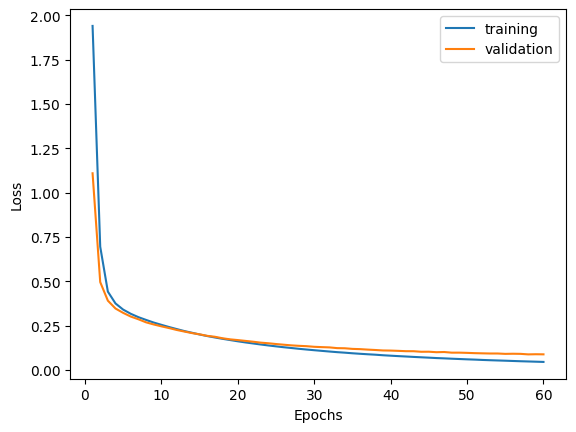

In [15]:
plt.plot(history[:,0], history[:,1], label="training")
plt.plot(history[:,0], history[:,2], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Test the network
Dropout and BatchNorm are not used in the network here we created. So, we just set the `torch.no_grad()` to disable gradient calculation in inference.

__[Appendix]:__ When we evaluate a network using PyTorch, we often use the `.eval()` function to set the network as an evaluation mode. The comments of the `eval()` function from the source code for torch.nn.modules.module are following:
>   """Sets the module in evaluation mode.  
    This has any effect only on certain modules. See documentations of  
    particular modules for details of their behaviors in training/evaluation  
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,  
    etc.
    """

In [16]:
# Load the saved model
net_eval = MLP()
params = torch.load("saved_model/best_weight.pt")
net_eval.load_state_dict(params)
net_eval.to("cpu")

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

test_loss = np.array([])
test_labels = np.array([])
pred_labels = np.array([])

with torch.no_grad():
    for batch_i, data in enumerate(test_loader):
        # get input tensors
        inputs, labels = data
        # reshape the shape of the inputs data
        inputs = inputs.view(-1, 28*28)
        # set target device
        inputs, labels = inputs.to("cpu"), labels.to("cpu")
        
        # forward pass
        logits = net_eval(inputs)
        # calculate the loss
        loss = criterion(logits, labels)
        
        # true label
        true_label = labels.numpy()
        # predict label
        pred_label = logits.argmax(dim=1)
        
        test_loss = np.append(test_loss, loss.item())
        test_labels = np.append(test_labels, np.ndarray.flatten(true_label))
        pred_labels = np.append(pred_labels, np.ndarray.flatten(pred_label.numpy()))
    
# evaluate model
print("Test loss: ", test_loss.mean())
print("Classification report:\n %s"
      % (classification_report(test_labels, pred_labels)))
print("Confusion matrix:\n%s" % confusion_matrix(test_labels, pred_labels))
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

Test loss:  0.0842232102807018
Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       980
         1.0       0.98      0.99      0.99      1135
         2.0       0.97      0.98      0.97      1032
         3.0       0.96      0.98      0.97      1010
         4.0       0.97      0.97      0.97       982
         5.0       0.98      0.97      0.97       892
         6.0       0.98      0.98      0.98       958
         7.0       0.97      0.97      0.97      1028
         8.0       0.97      0.97      0.97       974
         9.0       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion matrix:
[[ 968    0    0    1    1    2    3    1    3    1]
 [   0 1121    2    1    0    1    4    1    5    0]
 [   5    1 1007    6    4    0    1    5    3    0]
 [   0   